<a href="https://colab.research.google.com/github/KrinaKansara/codec-tasks/blob/main/task2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

          ds    y
0 1949-01-01  112
1 1949-02-01  118
2 1949-03-01  132
3 1949-04-01  129
4 1949-05-01  121
Prophet MAE: 33.43
Prophet RMSE: 43.07


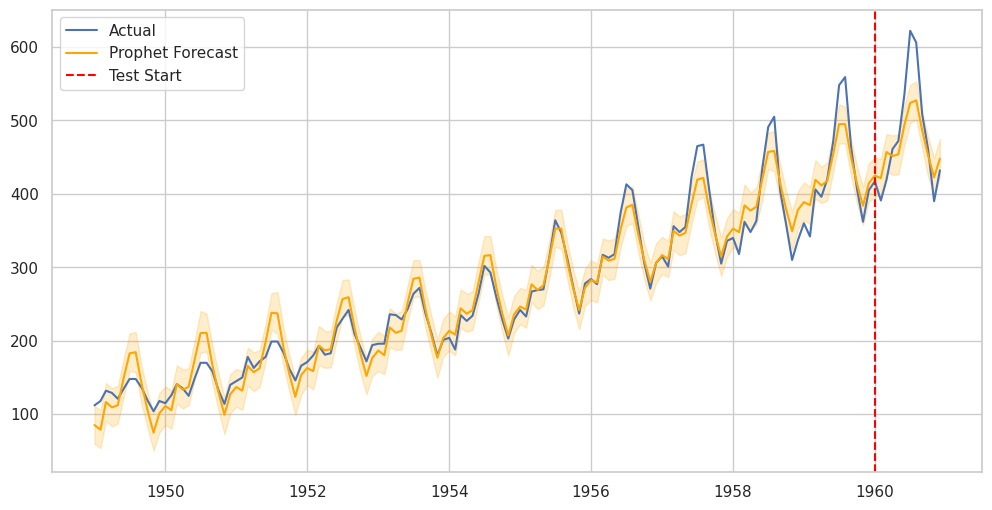

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA MAE: 16.31
SARIMA RMSE: 21.18


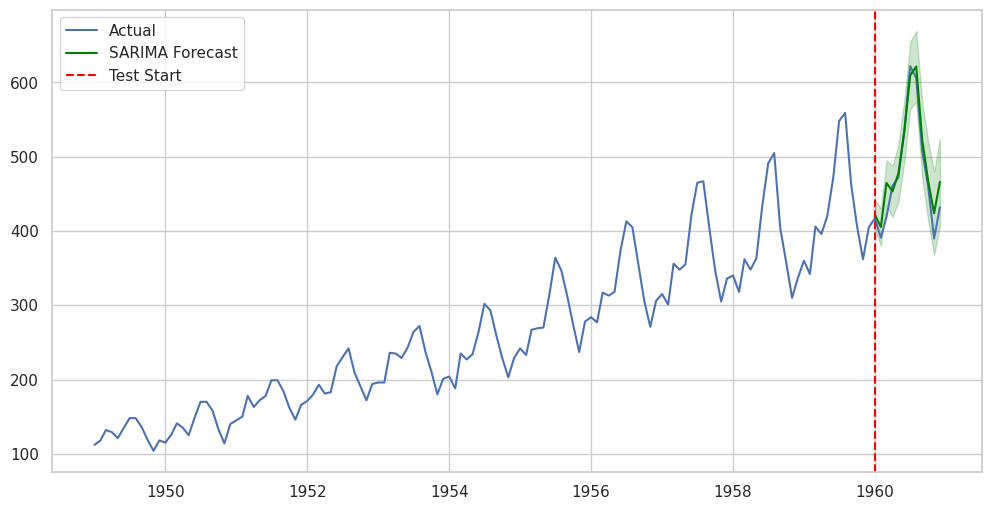

In [2]:
!pip install prophet matplotlib seaborn pandas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from prophet import Prophet
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

sns.set(style="whitegrid")

url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
df = pd.read_csv(url)
df.columns = ["ds", "y"]
df["ds"] = pd.to_datetime(df["ds"])

df = df.set_index("ds").asfreq("MS").reset_index()

print(df.head())

train = df.iloc[:-12]
test = df.iloc[-12:]

prophet_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False
)

prophet_model.fit(train)

future = prophet_model.make_future_dataframe(periods=12, freq="MS")
forecast = prophet_model.predict(future)

forecast_test = forecast[forecast["ds"].isin(test["ds"])]

prophet_mae = mean_absolute_error(test["y"], forecast_test["yhat"])
prophet_rmse = np.sqrt(mean_squared_error(test["y"], forecast_test["yhat"]))

print(f"Prophet MAE: {prophet_mae:.2f}")
print(f"Prophet RMSE: {prophet_rmse:.2f}")

plt.figure(figsize=(12,6))
plt.plot(df["ds"], df["y"], label="Actual")
plt.plot(forecast["ds"], forecast["yhat"], label="Prophet Forecast", color="orange")
plt.fill_between(
    forecast["ds"],
    forecast["yhat_lower"],
    forecast["yhat_upper"],
    color="orange",
    alpha=0.2
)
plt.axvline(test["ds"].iloc[0], color="red", linestyle="--", label="Test Start")
plt.legend()
plt.show()

train_arima = train.set_index("ds")
test_arima = test.set_index("ds")

sarima_model = SARIMAX(
    train_arima["y"],
    order=(1,1,1),
    seasonal_order=(1,1,1,12)
)

sarima_result = sarima_model.fit(disp=False)

sarima_forecast = sarima_result.get_forecast(steps=12)
sarima_pred = sarima_forecast.predicted_mean

sarima_mae = mean_absolute_error(test_arima["y"], sarima_pred)
sarima_rmse = np.sqrt(mean_squared_error(test_arima["y"], sarima_pred))

print(f"SARIMA MAE: {sarima_mae:.2f}")
print(f"SARIMA RMSE: {sarima_rmse:.2f}")

plt.figure(figsize=(12,6))
plt.plot(df["ds"], df["y"], label="Actual")
plt.plot(test_arima.index, sarima_pred, label="SARIMA Forecast", color="green")
plt.fill_between(
    test_arima.index,
    sarima_forecast.conf_int().iloc[:,0],
    sarima_forecast.conf_int().iloc[:,1],
    color="green",
    alpha=0.2
)
plt.axvline(test["ds"].iloc[0], color="red", linestyle="--", label="Test Start")
plt.legend()
plt.show()